## Sub-topic generation

#### 1. keywords extraction
#### 2. Candidate pool extraction
#### 3. Clustering
#### 4. Topic assignment

In [1]:
import pandas as pd
import os
import string
import numpy as np
import hdbscan

import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.metrics.pairwise import cosine_similarity

import texthero as hero
from texthero import preprocessing

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import umap

import warnings
warnings.filterwarnings('ignore')

C:\Users\sri.sai.praveen.gadi\.virtualenvs\xxx-eAHl9Gue\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\sri.sai.praveen.gadi\.virtualenvs\xxx-eAHl9Gue\lib\site-packages\spacy\util.py:865: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
C:\Users\sri.sai.praveen.gadi\.virtualenvs\xxx-eAHl9Gue\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMa

In [2]:
import msgpack
import msgpack_numpy as m
m.patch()

import redis

In [3]:
rdb = redis.StrictRedis(
    host='host.docker.internal',
    port=6379,
)

# rdb.set('France', 'Paris')

In [4]:
tf_model = hub.load(os.getcwd()+ '/../../models/USE_model')

In [5]:
final_df = pd.read_pickle(os.getcwd()+'/../dataframes/retrieval_dataset.pkl')
final_df.head(2)

,page_id,query,label,text,text_len,noun_chunks,mean_nc_vec,title,published_date,source_url
0,210705_news_167749,Methode Architektur,3,"ROME, N.Y. – U.S. Air Force researchers are a...",467,"[N.Y., industry help, big improvement, small, ...","[[-0.010767139494419098, -0.001241824007593095...",SWaP embedded computing artificial intelligenc...,2020-04-27 07:30:41,https://www.militaryaerospace.com/computers/ar...
1,210705_news_499712,Methode Architektur,3,A recently published 156-page paper from a tea...,758,"[a recently publish 156-page paper, a team, Im...","[[-0.008159193210303783, -0.001107345684431493...",An Erlangen Programme to Establish the Geometr...,2021-05-17 11:45:17,https://syncedreview.com/2021/05/05/deepmind-p...


In [3]:
final_df = pd.read_pickle(os.getcwd()+'/../dataframes/quantum_rank_df.pkl')
final_df.head(2)

,id,query,ranking_label,text,text_len,lang,text_tokens,nc_vec,label,label_name,title,pubDate,url
0,210705_news_53540,Quantentechnologie,3,Nach Cyberangriffen auf den Bundestag und das ...,445,de,"[Cyberangriffe, der Bundestag, der Datennetzwe...","[[-0.01808716543018818, -0.0072739748284220695...",1,technology,Netze deutscher Ministerien: Quantenkommunikat...,2019-12-16 10:26:15,https://www.spiegel.de/netzwelt/netzpolitik/qu...
1,210705_news_509066,Quantentechnologie,2,"The following is the May 24, 2021 Congressiona...",506,en,"[the following, the May 24, 2021 Congressional...","[[-0.009140371344983578, -0.002850867807865143...",1,technology,Report on Military Applications for Quantum Co...,2021-05-27 14:12:00,https://news.usni.org/2021/05/27/report-on-mil...


In [6]:
custom_pipeline = [preprocessing.fillna,
                   preprocessing.remove_html_tags,
                   preprocessing.remove_urls,
                   preprocessing.remove_digits,
                   preprocessing.remove_whitespace,
                  ]

final_df['text_clean'] = hero.clean(final_df['text'], custom_pipeline)
# final_df.head(3)

In [7]:
stopwords_de = stopwords.words('german')
stopwords_en = stopwords.words('english')

with open(os.getcwd()+'/../../conf/stopwords_de.txt', 'r') as f:
    stopwords_de_extra = f.read().splitlines()

stopwords_full = []
stopwords_full.extend(stopwords_de)
stopwords_full.extend(stopwords_en)
stopwords_full.extend(stopwords_de_extra)

stopwords_full = [word.lower() for word in stopwords_full]

stop_all = set(stopwords_full + list(string.punctuation))

In [8]:
def get_modified_vectors(vec_data):
    
    new_data = []
    for val in vec_data:
        new_data.append(val)
    
    new_data = np.array(new_data).reshape(-1, 512)
    return new_data

def get_pool_vec(doc_vec_list, pool):
    
    doc_vec_list = get_modified_vectors(doc_vec_list)
    if pool == 'mean':
        return np.nanmean(doc_vec_list, axis=0)
    elif pool == 'max':
        return np.nanmax(doc_vec_list, axis=0)

def get_document_vec(text):
    
    return tf_model(text)['outputs'].numpy()[0].reshape(1, -1)

def get_representation_vector(document, title):
    
    title_vec = get_document_vec(title)
    
    document_tokens = document.split()
    doc_len = len(document_tokens)
    doc_vecs = []
    
    doc_vecs.append(title_vec)
    
    if doc_len < 550:
        doc_vecs.append(get_document_vec(document))
    else:
        doc_parts = int(doc_len/500)
        for idx in range(doc_parts):
            if (idx+1)*500 >= doc_len:
                doc_temp = ' '.join(document_tokens[idx*500:])
            else:
                doc_temp = ' '.join(document_tokens[idx*500:(idx+1)*500])
                
            doc_vecs.append(get_document_vec(doc_temp))
        
    return get_pool_vec(get_modified_vectors(doc_vecs), pool='mean')

def get_shorter_text(phrase_1, phrase_2):
    
    if len(phrase_1) < len(phrase_2):
        return phrase_1
    else:
        return phrase_2
    
def remove_stopwords(noun_chunks):
    
    filtered_noun_chunks = []
    
    for word_token in noun_chunks:
        if word_token.lower() not in stop_all:
            filtered_noun_chunks.append(word_token)
            
    return filtered_noun_chunks

def get_filtered_nc(noun_chunks):
    
    noun_chunks = list(set(noun_chunks))
    noun_chunks = remove_stopwords(noun_chunks)
    phrases_len = len(noun_chunks)
    remove_phrases = [] 

    for idx_1 in range(phrases_len):

        phrase_1 = noun_chunks[idx_1]
        for idx_2 in range(idx_1 + 1, phrases_len):
            phrase_2 = noun_chunks[idx_2]

            if fuzz.ratio(phrase_1, phrase_2) > 80:
                remove_phrases.append(get_shorter_text(phrase_1, phrase_2))

    final_noun_chunks = list(set(noun_chunks) - set(remove_phrases))
    return final_noun_chunks

def get_sent_transformers_keywords(repr_vec, noun_chunks, query_vec, max_keyword_cnt = 30):
    
    noun_chunks = get_filtered_nc(noun_chunks)
    candidate_embeddings = [tf_model(nc)['outputs'].numpy()[0] for nc in noun_chunks]
    
    data_insert_dict = dict()
    
    kw_distances = cosine_similarity([repr_vec], candidate_embeddings)
    
    keywords = []
    for index in kw_distances.argsort()[0][-max_keyword_cnt:]: 
        data_insert_dict[noun_chunks[index]] =  m.packb(candidate_embeddings[index])
        keywords.append(noun_chunks[index])
        
    rdb.mset(data_insert_dict)
        
    return keywords

def get_sent_transformers_keywords_use(keywords, query_vec, max_keyword_cnt = 30):
    
    candidate_embeddings_keywords = [tf_model(kw)['outputs'].numpy()[0] for kw in keywords]
        
    query_distances = cosine_similarity([query_vec], candidate_embeddings_keywords)
    subtopic_keywords_dict = dict()
    for index in query_distances.argsort()[0][-max_keyword_cnt:]: 
        
        subtopic_keywords_dict[keywords[index]] = query_distances[0][index]
    
    subtopic_keywords_dict = sorted(subtopic_keywords_dict.items(), key=lambda x: x[1], reverse=True)

    return subtopic_keywords_dict

def get_sent_transformers_keywords_redis(keywords, query_vec, max_keyword_cnt = 30):
    
    candidate_embeddings_keywords = [m.unpackb(rdb.get(kw)) for kw in keywords]
    
    query_distances = cosine_similarity([query_vec], candidate_embeddings_keywords)
    subtopic_keywords_dict = dict()
    for index in query_distances.argsort()[0][-max_keyword_cnt:]: 
        
        subtopic_keywords_dict[keywords[index]] = query_distances[0][index]
    
    subtopic_keywords_dict = sorted(subtopic_keywords_dict.items(), key=lambda x: x[1], reverse=True)

    return subtopic_keywords_dict

def get_candidate_pool(subtopic_keywords_list):
    
    candidate_pool = []
    
    lower_limit = 0.2
    upper_limit = 0.4
    
    for key, value in subtopic_keywords_list:
        
        if value > 0.2 and value < 0.4:
            candidate_pool.append(key)
            
    return candidate_pool

In [10]:
query = 'Quantentechnologie'

query_vec = tf_model(query)['outputs'].numpy()[0]

In [12]:
final_df['doc_repr_vec'] = final_df.apply(lambda x:get_representation_vector(x['text_clean'], x['title']), axis=1)

In [13]:
%timeit final_df['keywords'] = final_df.apply(lambda x:get_sent_transformers_keywords(x['doc_repr_vec'], x['noun_chunks'], query_vec, max_keyword_cnt = 30), axis=1)

ConnectionError: Error 10053 while writing to socket. Eine bestehende Verbindung wurde softwaregesteuert
durch den Hostcomputer abgebrochen.

In [14]:
final_df.columns

Index(['page_id', 'query', 'label', 'text', 'text_len', 'noun_chunks',
       'mean_nc_vec', 'title', 'published_date', 'source_url', 'text_clean',
       'doc_repr_vec'],
      dtype='object')

In [ ]:
final_df.drop_columns(['text_clean'])
final_df.to_pickle(os.getcwd()+'/../dataframes/retrieval_dataset.pkl')

In [13]:
%timeit final_df['keywords'] = final_df.apply(lambda x:get_sent_transformers_keywords(x['doc_repr_vec'], x['text_tokens'], query_vec, max_keyword_cnt = 30), axis=1)

1min 22s ± 436 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit final_df['keywords_use'] = final_df.apply(lambda x:get_sent_transformers_keywords_use(x['keywords'], query_vec, max_keyword_cnt = 30), axis=1)

25.5 s ± 154 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit final_df['keywords_rdb'] = final_df.apply(lambda x:get_sent_transformers_keywords_redis(x['keywords'], query_vec, max_keyword_cnt = 30), axis=1)

943 ms ± 43.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
final_df['candidate_pool'] = final_df.apply(lambda x:get_candidate_pool(x['keywords_use']), axis=1)

In [107]:
get_sent_transformers_keywords(final_df.doc_repr_vec[0], final_df.text_tokens[0], query_vec, max_keyword_cnt = 30)

[('Quantentechnologien', 0.99378365),
 ('der Quanteninformation', 0.621655),
 ('der Quantenphysik', 0.54227066),
 ('der Quantenkommunikation', 0.5379448),
 ('Quantenrepeater', 0.5358043),
 ('ein Quant', 0.50813645),
 ('QuNet', 0.42542356),
 ('sogenannter Quantenrepeater', 0.4179596),
 ('der sogenannter Quantenkommunikation', 0.3961449),
 ('Kommunikation', 0.36897558),
 ('der Bundestags-IT', 0.33925346),
 ('Cyberangriffe', 0.3357282),
 ('ein --abhörsicher Quantennetz', 0.3317344),
 ('Datensicherheit', 0.32892507),
 ('Kanzleramt', 0.31358832),
 ('der Datennetzwerk', 0.28580377),
 ('ein quantengesichert Videokonferenz', 0.26693088),
 ('Datenverbindung', 0.2649808),
 ('heterogen Netzwerke', 0.25009),
 ('übertragen Information', 0.2424685),
 ('sicher Kommunikationsnetz', 0.23277518),
 ('Bundesnetzbetreibern', 0.21559438),
 ('nicht auf mathematisch basiert Strategie', 0.21250601),
 ('der Forschungsministerium', 0.21107861),
 ('der neu Datenleitung', 0.1854986),
 ('zwei Bundeseinrichtung', 0.

In [108]:
get_sent_transformers_keywords(final_df.doc_repr_vec[1], final_df.text_tokens[1], query_vec, max_keyword_cnt = 30)

[('Quantum Technology', 0.81225383),
 ('technological application', 0.576806),
 ('quantum system', 0.543468),
 ('quantum computer', 0.5308959),
 ('quantum communication', 0.520388),
 ('Quantum application', 0.5009754),
 ('quantum bit', 0.49300754),
 ('Quantum sensing', 0.49085987),
 ('quantum radar', 0.47127515),
 ('quantum physics', 0.4616241),
 ('Sciences', 0.432706),
 ('a compute unit', 0.3997519),
 ('Quantum Sensing\xa0 Quantum sensing', 0.39084092),
 ('a quantum computer increase', 0.37369415),
 ('electronic warfare capability', 0.32418722),
 ('NAS', 0.31425458),
 ('two or more quantum object', 0.31178305),
 ('the Defense Science Board', 0.3003675),
 ('nuclear material', 0.29672897),
 ('military', 0.29387018),
 ('encode information', 0.2733398),
 ('military personnel', 0.24680126),
 ('military sensing', 0.23773894),
 ('Military Applications', 0.23499191),
 ('Defense Primer', 0.22897533),
 ('enhanced military capability', 0.2269738),
 ('the National Academy', 0.20023635),
 ('potent

In [109]:
get_sent_transformers_keywords(final_df.doc_repr_vec[2], final_df.text_tokens[2], query_vec, max_keyword_cnt = 30)

[('Quantum computing', 0.6012658),
 ('the CERN Quantum Technology Initiative', 0.52976155),
 ('quantum annealing', 0.52378696),
 ('algorithm', 0.47221375),
 ('quantum machine learning', 0.4689152),
 ('quantum physics', 0.4616241),
 ('actual quantum computer', 0.45516345),
 ('important quantum algorithm', 0.43744746),
 ('quantum simulator', 0.42929018),
 ('quantum compute\n       a series', 0.42479184),
 ('CERN', 0.40608716),
 ('quantum variational classifier', 0.39122272),
 ('the Computer Science Department', 0.38876498),
 ('the variational quantum eigensolver', 0.3828769),
 ('the IBM Quantum Experience', 0.3407883),
 ('the quantum circuit model', 0.33540055),
 ('quantum support vector machine', 0.3334496),
 ('(BB84, quantum teleportation', 0.32437554),
 ('CERN openlab', 0.31006056),
 ('chemistry simulation', 0.30911267),
 ('the University', 0.30006924),
 ('basic linear algebra', 0.2498492),
 ('new lecture', 0.24594848),
 ('weekly lecture', 0.24102129),
 ('high-energy physics problem',

In [110]:
get_sent_transformers_keywords(final_df.doc_repr_vec[3], final_df.text_tokens[3], query_vec, max_keyword_cnt = 30)

[('der Quanten-Eigenschaft', 0.6304775),
 ('jeglicher Quanten-System', 0.58393824),
 ('Quanten-Bits', 0.5657451),
 ('jeder Quantencomputer', 0.5396085),
 ('Quanten-Experimente', 0.51809406),
 ('Quanten-Forscher', 0.49203813),
 ('Qubits', 0.4644632),
 ('sodass echt Quantencomputing', 0.45882294),
 ('solcher Quanten-Bit', 0.43737507),
 ('mehr Zahlen-Variatione', 0.41835287),
 ('ein Quantencomputer-Forscher', 0.41234338),
 ('ihr Quantenzustand', 0.39938062),
 ('auch Qubits', 0.37025714),
 ('der Computer', 0.36913356),
 ('Strahlung', 0.35180277),
 ('Elektronen-Paar', 0.34524807),
 ('der Teilchenphysik', 0.33493495),
 ('selbst einiger Millisekunde', 0.31086254),
 ('Kosmische Strahlung', 0.30798897),
 ('geladen Elektronen-Paar', 0.30030715),
 ('ein solcher Qubit-Zustand', 0.2876907),
 ('konkret Wert', 0.27971432),
 ('natürlich Strahlung', 0.26929423),
 ('dunkel Materie', 0.26583263),
 ('wie sehr Strahlung', 0.25712907),
 ('bestrahlte Kupfer', 0.20833221),
 ('subatomar Partikel', 0.19769531),

In [111]:
get_sent_transformers_keywords(final_df.doc_repr_vec[4], final_df.text_tokens[4], query_vec, max_keyword_cnt = 30)

[('the technology', 0.6901102),
 ('Quantum computing', 0.6012658),
 ('different quantum hardware technology', 0.58821034),
 ('computing', 0.558813),
 ('quantum algorithm', 0.5498059),
 ('quantum mechanic', 0.53955203),
 ('quantum compute hardware', 0.45082703),
 ('quantum annealer', 0.44582573),
 ('different quantum computer', 0.4437202),
 ('chemical engineering', 0.4329464),
 ('your own quantum algorithm', 0.40138796),
 ('expertise', 0.3959148),
 ('your algorithm', 0.38710028),
 ('material science', 0.3820883),
 ('computational problem', 0.38060182),
 ('quantum circuit simulator', 0.36164755),
 ('new skill', 0.35454324),
 ('IonQ.', 0.34593052),
 ('machine learning', 0.34333718),
 ('researcher', 0.32982093),
 ('discovery', 0.32080126),
 ('classical computer', 0.31379676),
 ('simulator', 0.30000114),
 ('a fully manage quantum computing service', 0.28985125),
 ('gate-base computer', 0.27467966),
 ('pre-build algorithm', 0.24240135),
 ('drug discovery', 0.2271811),
 ('Amazon Braket', 0.17

### 3. Clustering

In [136]:
final_candidate_pool = []

for idx, row in final_df.iterrows():
    final_candidate_pool.extend(row['candidate_pool'])

In [164]:
def get_umap_output(vec_array, dim_size=5):
    
    umap_obj = umap.UMAP(n_neighbors=40, 
                        n_components=dim_size, 
                        min_dist=0.01,
                        metric='cosine',
                        random_state=123).fit(vec_array) 
    
    umap_output = umap_obj.transform(vec_array) 
    return umap_output, umap_obj

def get_hdbscan_output(data_points, cluster_size=7):
    
    hdbscan_output = hdbscan.HDBSCAN(
        #min_cluster_size=cluster_size,
#                                       min_samples=2,
                                      metric='euclidean',
                                     cluster_selection_method='eom').fit(data_points)
    return hdbscan_output

def project_on_2Dplane(umap_output, cluster_ids):
    
    umap_df = pd.DataFrame(np.column_stack((umap_output, cluster_ids)), columns=['x', 'y', 'cluster ids'])
    grid = sns.FacetGrid(umap_df, hue='cluster ids', height=7)
    grid.map(plt.scatter, 'x', 'y').add_legend()

In [137]:
final_candidate_pool_vecs = [tf_model(nc)['outputs'].numpy()[0] for nc in final_candidate_pool]

In [142]:
df_data = []
for word, vec in zip(final_candidate_pool, final_candidate_pool_vecs):
    df_data.append((word, vec))

cluster_df = pd.DataFrame(df_data, columns= ['candidate_words', 'candidate_vecs'])
cluster_df.sample(2)

,candidate_words,candidate_vecs
85,der Ionenfallen-Computer,"[-0.021121925, -0.0335759, -0.041325208, -0.01..."
68,machine learning,"[-0.008927658, -0.025966378, -0.034051377, 0.0..."


In [182]:
def get_clustering_analysis(dimen_size=5, cluster_size=7):
    
    umap_output_5, umap_5 = get_umap_output(final_candidate_pool_vecs, dim_size=dimen_size)
    hdbscan_output = get_hdbscan_output(umap_output_5, cluster_size=cluster_size)
    
    cluster_df['cluster_id'] = hdbscan_output.labels_
    cluster_df.cluster_id.hist(bins=150)
    
    umap_output_2, umap_2 = get_umap_output(final_candidate_pool_vecs, dim_size=2)
    project_on_2Dplane(umap_output_2, cluster_df['cluster_id'])

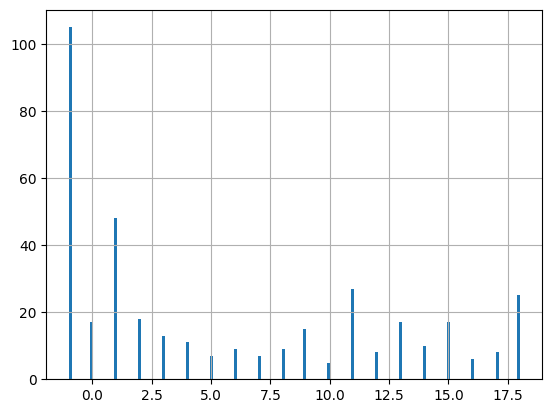

In [165]:
get_clustering_analysis(dimen_size=5, cluster_size=8)

In [188]:
# cluster_df.cluster_id.value_counts()

In [175]:
cluster_data = []

for cluster_id in set(cluster_df.cluster_id.values):
    
    if cluster_id != -1:
        df = cluster_df[cluster_df['cluster_id'] == cluster_id]
        cluster_data.append((cluster_id, df.candidate_words.values, df.candidate_vecs.values))

In [176]:
cluster_data_df = pd.DataFrame(cluster_data, columns=['cluster_id', 'candidate_words', 'candidate_vecs'])
cluster_data_df.sample(2)

,cluster_id,candidate_words,candidate_vecs
8,8,"[electronic warfare capability, military, mili...","[[0.017449051, 0.068132706, 0.029964415, 0.002..."
7,7,"[chemistry simulation, simulator, Simulation, ...","[[-0.05543056, 0.008927665, -0.016811466, -0.0..."


### 4. Topic assignment

In [189]:
def get_nearest_keyword(keywords, keyword_vecs, mean_vec):
    
    query_distances = cosine_similarity([mean_vec], list(keyword_vecs))
    subtopic_keywords_dict = dict()
    for index in query_distances.argsort()[0]: 
        
        subtopic_keywords_dict[keywords[index]] = query_distances[0][index]
    
    subtopic_keywords_dict = sorted(subtopic_keywords_dict.items(), key=lambda x: x[1], reverse=True)
    return subtopic_keywords_dict[0][0]

In [177]:
cluster_data_df['mean_vec'] = cluster_data_df.apply(lambda x:get_pool_vec(x['candidate_vecs'], 'mean'), axis=1)

In [184]:
cluster_data_df['topic'] = cluster_data_df.apply(lambda x:get_nearest_keyword(x['candidate_words'], x['candidate_vecs'], x['mean_vec']), axis=1)

In [187]:
cluster_data_df[['cluster_id', 'candidate_words', 'topic']]

,cluster_id,candidate_words,topic
0,0,"[the IBM Quantum Experience, Intel, IBM, der I...",IBM
1,1,"[der Bundestags-IT, Kanzleramt, NAS, the Natio...",der BSI
2,2,"[nicht auf mathematisch basiert Strategie, bas...",solcher Algorithm
3,3,"[Cyberangriffe, Datensicherheit, der Datennetz...",der Datennetzwerk
4,4,"[der sogenannter Quantenkommunikation, ein --a...",ein quantensicher Verbindung
5,5,"[elektronisch nulldimensional Quantenpunkte, G...",--nulldimensional-- Quantenpunkte
6,6,"[Quantum Sensing Quantum sensing, the variati...",Quantum Sensing Quantum sensing
7,7,"[chemistry simulation, simulator, Simulation, ...",simulator
8,8,"[electronic warfare capability, military, mili...",military
9,9,"[Elektronen-Paar, der Teilchenphysik, geladen ...",der Teilchenphysik
